In [1]:
import osmnx as ox, networkx as nx, numpy as np
ox.config(log_console=True, use_cache=True)

In [2]:
B = ox.buildings.buildings_from_address('345 W 35th St, New York, New York',distance=300, retain_invalid=False)

In [3]:
# the way to extract the polygon of original data, it turns out that the polygon of buildings is 
# irrelated to the intersection, which is not useful
list(B['geometry'].exterior)[1].coords.xy

(array('d', [-73.9908279, -73.9933828, -73.9932658, -73.9932168, -73.9931589, -73.993095, -73.9930314, -73.9916893, -73.991588, -73.9914904, -73.9914809, -73.9914425, -73.9913287, -73.9913078, -73.9913822, -73.9913778, -73.9913522, -73.9913266, -73.9912883, -73.99125, -73.9912116, -73.9900333, -73.990431, -73.9904765, -73.9908279]),
 array('d', [40.7560875, 40.7571569, 40.7573174, 40.7573846, 40.7574639, 40.7575515, 40.7576387, 40.757077, 40.7571168, 40.7571552, 40.7571686, 40.7572216, 40.7573785, 40.7574077, 40.7574389, 40.7574448, 40.7574801, 40.7575154, 40.757568, 40.7576207, 40.7576735, 40.7571812, 40.7566322, 40.7565693, 40.7560875]))

In [4]:
centroidseries = B['geometry'].centroid

In [5]:
# Collect the data of building height
import pandas as pd
df = pd.concat([centroidseries.x, centroidseries.y,B['height']], axis=1)
df.columns = ['x','y','height']
df = df.dropna()
df

,x,y,height
35938543,-73.992203,40.749968,126
108160358,-73.991530,40.756955,38.6
138147417,-73.992586,40.750144,15
264667021,-73.998132,40.753054,57.8
264674596,-73.996847,40.750881,34.3
264674601,-73.997615,40.751022,13.5
264674611,-73.998165,40.751475,26.0
264674613,-73.997317,40.751081,72.6
264674614,-73.997701,40.750904,41.1
265258258,-73.995188,40.753215,20.5


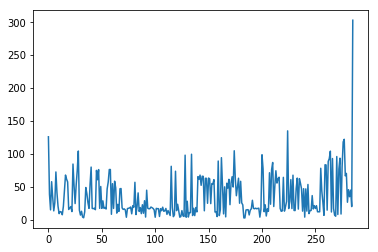

In [6]:
# histogram of the building height
import numpy as np
import matplotlib.pyplot as plt
hh = [float(a) for a in list(df['height'])]
plt.plot(hh)
plt.show()

In [7]:
# filter the map and visulize
G = ox.graph_from_address('345 W 35th St, New York, New York', network_type='drive',distance=300)

In [8]:
Roads = list(G.edges())

In [9]:
# remove the unnecessary road and node
# keep {'primary', 'secondary', 'tertiary', 'residential', 'trunk'} only
for r in Roads:
    proper = G.adj[r[0]][r[1]][0]['highway']
    if 'motor' in proper or 'motor_link' in proper:
        G.remove_edge(r[0],r[1])

In [10]:
Roads = list(G.edges())
node_list = []
for r in Roads:
    node_list.append(r[0])
    node_list.append(r[1])
node_list = set(node_list)

In [11]:
# we need an undirected graph to find neighbors of each node
G_undir = G.to_undirected()

In [12]:
# remove dead end and single node
do = 1
while do > 0:
    Nodes = list(G.nodes())
    G_undir = G.to_undirected()
    for n in Nodes:
        if n not in node_list or len([a for a in G_undir.neighbors(n)]) == 1:
            G.remove_node(n)
    do = len(Nodes) - len(G)

In [13]:
# remove the point that has only two neighbors and is not the boundary point
do = 1
while do > 0:
    Nodes = list(G.nodes())
    G_undir = G.to_undirected()
    for n in Nodes:
        nei = [a for a in G_undir.neighbors(n)]
        if len(nei) == 2:
            slope1 = (G_undir.node[nei[0]]['y']-G_undir.node[n]['y'])/(G_undir.node[nei[0]]['x']-G_undir.node[n]['x'])
            slope2 = (G_undir.node[nei[1]]['y']-G_undir.node[n]['y'])/(G_undir.node[nei[1]]['x']-G_undir.node[n]['x'])
            diff = slope1 - slope2
            if -0.1 < diff < 0.1:
                # remove that node but keep the edges
                G.remove_node(n)
                G.add_edge(nei[0],nei[1])
                break
    do = len(Nodes) - len(G)

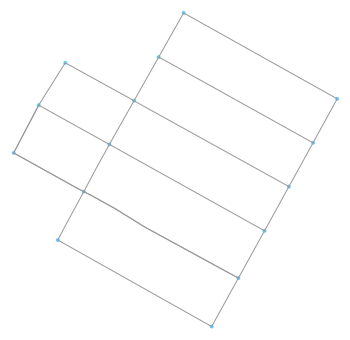

(<Figure size 588.257x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22cba105fd0>)

In [14]:
ox.plot_graph(G)

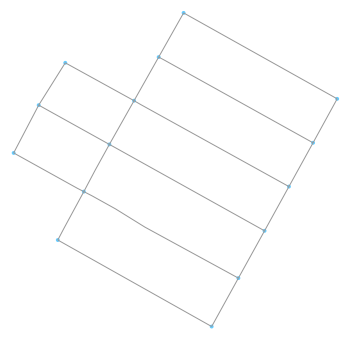

(<Figure size 588.257x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22cba4511d0>)

In [15]:
ox.plot_graph(G_undir)

In [89]:
# add building as new nodes
for i in range(len(df)):
    G.add_node(str(i))
    G.node[str(i)]['x'] = df.iloc[i]['x']
    G.node[str(i)]['y'] = df.iloc[i]['y']
    G.node[str(i)]['height'] = df.iloc[i]['height']

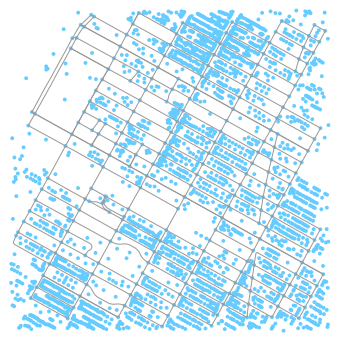

(<matplotlib.figure.Figure at 0x29226b3be10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29226b336d8>)

In [404]:
ox.plot_graph(G)

In [16]:
def slope_cal(a,b,n):
    slope1 = (G_undir.node[a]['y']-G_undir.node[n]['y'])/(G_undir.node[a]['x']-G_undir.node[n]['x'])
    slope2 = (G_undir.node[b]['y']-G_undir.node[n]['y'])/(G_undir.node[b]['x']-G_undir.node[n]['x'])
    diff = slope1 - slope2
    return diff

In [17]:
# Create polygon of the block
block = []
for n in Nodes:
    nei = [a for a in G_undir.neighbors(n)]
    G_test = G_undir.copy()
    G_test.remove_node(n)
    if len(nei) == 2:
        path = nx.bidirectional_shortest_path(G_test, nei[0],nei[1])
        box = [n] + path
        block.append(box)
    elif len(nei) == 3:
        diff1 = slope_cal(nei[0],nei[1],n)
        diff2 = slope_cal(nei[0],nei[2],n)
        diff3 = slope_cal(nei[1],nei[2],n)
        if abs(diff1) > 0.1:
            path1 = nx.bidirectional_shortest_path(G_test, nei[0],nei[1])
            box1 = [n] + path1
            block += [box1]
        if abs(diff2) > 0.1:
            path2 = nx.bidirectional_shortest_path(G_test, nei[0],nei[2])
            box2 = [n] + path2
            block += [box2]
        if abs(diff3) > 0.1:
            path3 = nx.bidirectional_shortest_path(G_test, nei[1],nei[2])
            box3 = [n] + path3
            block += [box3]
    elif len(nei) == 4:
        diff1 = slope_cal(nei[0],nei[1],n)
        diff2 = slope_cal(nei[0],nei[2],n)
        diff3 = slope_cal(nei[0],nei[3],n)
        diff4 = slope_cal(nei[1],nei[2],n)
        diff5 = slope_cal(nei[1],nei[3],n)
        diff6 = slope_cal(nei[2],nei[3],n)
        if abs(diff1) > 0.1:
            path1 = nx.bidirectional_shortest_path(G_test, nei[0],nei[1])
            box1 = [n] + path1
            block += [box1]
        if abs(diff2) > 0.1:
            path2 = nx.bidirectional_shortest_path(G_test, nei[0],nei[2])
            box2 = [n] + path2
            block += [box2]
        if abs(diff3) > 0.1:
            path3 = nx.bidirectional_shortest_path(G_test, nei[0],nei[3])
            box3 = [n] + path3
            block += [box3]
        if abs(diff4) > 0.1:
            path4 = nx.bidirectional_shortest_path(G_test, nei[1],nei[2])
            box4 = [n] + path4
            block += [box4]
        if abs(diff5) > 0.1:
            path5 = nx.bidirectional_shortest_path(G_test, nei[1],nei[3])
            box5 = [n] + path5
            block += [box5]
        if abs(diff6) > 0.1:
            path6 = nx.bidirectional_shortest_path(G_test, nei[2],nei[3])
            box6 = [n] + path6
            block += [box6]     

In [18]:
block

[[42437663, 42444960, 1533280147, 42434427],
 [42437663, 42444960, 42435645, 42435644],
 [42437663,
  42444954,
  42435642,
  42435644,
  42435645,
  42444960,
  1533280147,
  42434427],
 [42437663, 42444954, 42435642, 42435644],
 [42435642, 42444954, 42437663, 42435644],
 [42435644, 42435642, 42444954, 42437663],
 [42435644, 42435645, 42444960, 42437663],
 [42435646, 42435650, 4491359481, 42444964],
 [42435646, 42444964, 42444960, 42435645],
 [42435650, 4491359481, 42433625, 42433620],
 [42435650, 4491359481, 42444964, 42435646],
 [42433620, 42433625, 4491359481, 42435650],
 [42433625, 4491359481, 42435650, 42433620],
 [42444954, 42435642, 42435644, 42437663],
 [42444964, 42444960, 1533280147, 42434429],
 [42444964, 42444960, 42435645, 42435646],
 [42444964,
  4491359481,
  42435650,
  42435646,
  42435645,
  42444960,
  1533280147,
  42434429],
 [42444964, 4491359481, 42435650, 42435646],
 [4491359481, 42433625, 42433620, 42435650],
 [4491359481, 42435650, 42435646, 42444964],
 [1533

In [19]:
# remove duplicate blocks
from collections import Counter
a_list = []
new_block = []
for b in block:
    if Counter(b) not in a_list:
        a_list.append(Counter(b))
        new_block.append(b)

In [20]:
# Remove the large blocks that comprised of small blocks
block_4 = [b for b in new_block if len(b) == 4]
block_3 = [b for b in new_block if len(b) == 3]
block_small = block_3 + block_4
block_large = []
for b in new_block:
    add = 1
    if len(b) > 4:
        key = list(Counter(b).keys())
        for b_small in block_small:
            key_small = list(Counter(b_small).keys())
            if all(elem in key for elem in key_small):  # the big block contains that small block
                add = 0
                break
        if add == 1:
            block_large.append(b)

In [21]:
# Now is the final blocks that has adjoint with each other
new_block = block_small + block_large

In [22]:
new_block

[[42437663, 42444960, 1533280147, 42434427],
 [42437663, 42444960, 42435645, 42435644],
 [42437663, 42444954, 42435642, 42435644],
 [42435646, 42435650, 4491359481, 42444964],
 [42435646, 42444964, 42444960, 42435645],
 [42435650, 4491359481, 42433625, 42433620],
 [42444964, 42444960, 1533280147, 42434429]]

In [23]:
def block_coord(b):
    coord = []
    for i in range(len(b)):
        x = G_undir.node[b[i]]['x']
        y = G_undir.node[b[i]]['y']
        coord += [[x,y]]
    return coord

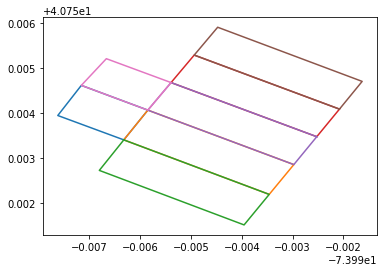

In [24]:
# plot block
import matplotlib.pyplot as plt
for b in new_block:
    coord = block_coord(b)
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #create lists of x and y values
    plt.plot(xs,ys)
plt.show()

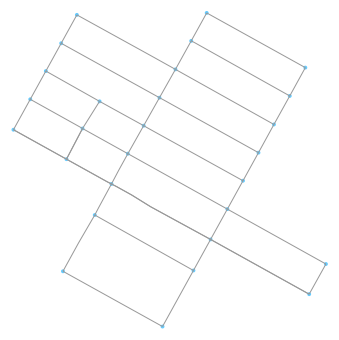

(<Figure size 568.194x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aabf0686a0>)

In [25]:
# Compare with the original 
# We find out that the some curved street that without node could not be plot accurate.
ox.plot_graph(G)

In [25]:
# check the accuracy of block by the nodes and edges
H = nx.MultiGraph()
for b in new_block:
    n = len(b)
    H.add_nodes_from(b)
    H.add_edge(b[0],b[n-1])
    for i in range(n-1):
        H.add_edge(b[i],b[i+1])

In [26]:
Roads = list(H.edges())
# remove the unnecessary road and node
# keep {'primary', 'secondary', 'tertiary', 'residential', 'trunk'} only
a_l = []
for r in Roads:
    if r in a_l:
        H.remove_edge(r[0],r[1])
    a_l.append(r)

In [27]:
H = H.to_undirected()

In [28]:
# Compare the node number and road number to the original map, which prove to be exactly the same!
n1 = list(H.nodes()) 
n2 = list(G_undir.nodes())

In [29]:
len(n1) == len(n2)

True

In [30]:
# the node are same
for x in n2:
    if x not in n1:
        print(x)

In [31]:
e1 = list(H.edges()) 
e2 = list(G_undir.edges())

In [32]:
len(e1) == len(e2)

True

In [117]:
for x in e2:
    if x not in e1 and x[::-1] not in e1:
        print(x)

In [33]:
def obtain_edge(b):
    edges = []
    b = b + [b[0]]
    n = len(b)
    for i in range(n-1):
        edges = edges + [(b[i],b[i+1]),(b[i+1],b[i])]
    return edges

In [34]:
# Create polygon and add heights
# Save the block information to the json file
# The information includes the nodes, edges, heights and coords.
import sys
import json
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import asShape
from shapely.geometry import mapping
Block = {}
for i in range(len(new_block)):
    b = new_block[i]
    Block[i] = {}
    Block[i]['nodes'] = b
    Block[i]['edges'] = obtain_edge(b)
    coords = [(G_undir.node[n]['x'],G_undir.node[n]['y']) for n in b]
    Block[i]['coords'] = coords
    Block[i]['height'] = 0
    poly = Polygon(coords)
    for j in range(len(df)):
        x, y, height = df.iloc[j]['x'], df.iloc[j]['y'], float(df.iloc[j]['height'])
        point = Point(x, y)
        if poly.contains(point):
            Block[i]['height'] = height
            break

In [35]:
Block

{0: {'coords': [(-73.9963173, 40.7534073),
   (-73.995845, 40.7540684),
   (-73.997152, 40.7546186),
   (-73.9976147, 40.753949)],
  'edges': [(42437663, 42444960),
   (42444960, 42437663),
   (42444960, 1533280147),
   (1533280147, 42444960),
   (1533280147, 42434427),
   (42434427, 1533280147),
   (42434427, 42437663),
   (42437663, 42434427)],
  'height': 52.1,
  'nodes': [42437663, 42444960, 1533280147, 42434427]},
 1: {'coords': [(-73.9963173, 40.7534073),
   (-73.995845, 40.7540684),
   (-73.9929759, 40.7528582),
   (-73.9934596, 40.7521959)],
  'edges': [(42437663, 42444960),
   (42444960, 42437663),
   (42444960, 42435645),
   (42435645, 42444960),
   (42435645, 42435644),
   (42435644, 42435645),
   (42435644, 42437663),
   (42437663, 42435644)],
  'height': 20.5,
  'nodes': [42437663, 42444960, 42435645, 42435644]},
 2: {'coords': [(-73.9963173, 40.7534073),
   (-73.9967986, 40.7527292),
   (-73.9939536, 40.7515176),
   (-73.9934596, 40.7521959)],
  'edges': [(42437663, 42444

In [36]:
# Output json file
with open('Block.json', 'w') as outfile:
    json.dump(Block, outfile)

In [37]:
# Assume there are three layers
h1 = 5
h2 =15
h3 = 35

In [38]:
# find all the nodes first
Node = []
for b in new_block:
    Node += b
Node = list(set(Node))

In [39]:
import itertools
def complete_edge(b):
    edges = [a for a in itertools.combinations(b, 2)] + [a[::-1] for a in itertools.combinations(b, 2)]
    return edges

In [40]:
Block[0]

{'coords': [(-73.9963173, 40.7534073),
  (-73.995845, 40.7540684),
  (-73.997152, 40.7546186),
  (-73.9976147, 40.753949)],
 'edges': [(42437663, 42444960),
  (42444960, 42437663),
  (42444960, 1533280147),
  (1533280147, 42444960),
  (1533280147, 42434427),
  (42434427, 1533280147),
  (42434427, 42437663),
  (42437663, 42434427)],
 'height': 52.1,
 'nodes': [42437663, 42444960, 1533280147, 42434427]}

In [41]:
# Roads on layer 1
Edges_1 = []
for i in range(len(Block)):
    # cannot crossover
    if Block[i]['height'] > h1:
        Edges_1 += Block[i]['edges']
    # crossover
    else:
        edges = complete_edge(Block[i]['nodes'])
        Edges_1 += edges
Edges_1 = list(set(Edges_1))        

In [42]:
Edges_1 = [(a[0],a[1],1) for a in Edges_1]

In [43]:
# Roads on layer 2
Edges_2 = []
for i in range(len(Block)):
    # cannot crossover
    if Block[i]['height'] > h2:
        Edges_2 += Block[i]['edges']
    # crossover
    else:
        edges = complete_edge(Block[i]['nodes'])
        Edges_2 += edges
Edges_2 = list(set(Edges_2))   

In [44]:
Edges_2 = [(a[0],a[1],2) for a in Edges_2]

In [45]:
# Roads on layer 3
Edges_3 = []
for i in range(len(Block)):
    # cannot crossover
    if Block[i]['height'] > h3:
        Edges_3 += Block[i]['edges']
    # crossover
    else:
        edges = complete_edge(Block[i]['nodes'])
        Edges_3 += edges
Edges_3 = list(set(Edges_3))   

In [46]:
Edges_3 = [(a[0],a[1],3) for a in Edges_3]

In [47]:
# define the new edge that come from the lower layer to higher layer
Edges_4 = [(a,a,1.2) for a in Node]
Edges_5 = [(a,a,2.2) for a in Node]
# define the new edge that come from the higher layer to lower layer
Edges_6 = [(a,a,1.8) for a in Node]
Edges_7 = [(a,a,2.8) for a in Node]

In [48]:
Total_edges = Edges_1 + Edges_2 + Edges_3 + Edges_4 + Edges_5 + Edges_6 + Edges_7

In [49]:
Segment = {}
for i in range(len(Total_edges)):
    r = Total_edges[i]
    Segment[i] = {}
    Segment[i]['road'] = r
    if r[2] == 1:
        Segment[i]['height'] = h1
    if r[2] == 1.2:
        Segment[i]['height'] = h1 + 0.2*(h2-h1)
    if r[2] == 1.8:
        Segment[i]['height'] = h1 + 0.8*(h2-h1)
    if r[2] == 2:
        Segment[i]['height'] = h2
    if r[2] == 2.2:
        Segment[i]['height'] = h2 + 0.2*(h3-h2)
    if r[2] == 2.8:
        Segment[i]['height'] = h2 + 0.8*(h3-h2)
    if r[2] == 3:
        Segment[i]['height'] = h3
    Segment[i]['x'] = [G_undir.node[r[0]]['x'],G_undir.node[r[1]]['x']]
    Segment[i]['y'] = [G_undir.node[r[0]]['y'],G_undir.node[r[1]]['y']]

In [50]:
# Output json file
with open('Segment.json', 'w') as outfile:
    json.dump(Segment, outfile)

In [51]:
Segment

{0: {'height': 5,
  'road': (42433620, 42433625, 1),
  'x': [-73.991633, -73.9944724],
  'y': [40.754707, 40.7559104]},
 1: {'height': 5,
  'road': (1533280147, 42434429, 1),
  'x': [-73.997152, -73.9966605],
  'y': [40.7546186, 40.7552114]},
 2: {'height': 5,
  'road': (42435645, 42435646, 1),
  'x': [-73.9929759, -73.9925251],
  'y': [40.7528582, 40.7534779]},
 3: {'height': 5,
  'road': (42444960, 1533280147, 1),
  'x': [-73.995845, -73.997152],
  'y': [40.7540684, 40.7546186]},
 4: {'height': 5,
  'road': (42437663, 42444954, 1),
  'x': [-73.9963173, -73.9967986],
  'y': [40.7534073, 40.7527292]},
 5: {'height': 5,
  'road': (42435646, 42435645, 1),
  'x': [-73.9925251, -73.9929759],
  'y': [40.7534779, 40.7528582]},
 6: {'height': 5,
  'road': (42437663, 42434427, 1),
  'x': [-73.9963173, -73.9976147],
  'y': [40.7534073, 40.753949]},
 7: {'height': 5,
  'road': (42444960, 42437663, 1),
  'x': [-73.995845, -73.9963173],
  'y': [40.7540684, 40.7534073]},
 8: {'height': 5,
  'road':

In [52]:
# Also three layers of intersection
Node_1 = [(a,1) for a in Node]
Node_2 = [(a,2) for a in Node]
Node_3 = [(a,3) for a in Node]
Total_node = Node_1 + Node_2 + Node_3

In [53]:
Intersection = {}
for i in range(len(Total_node)):
    Intersection[i] = {}
    n = Total_node[i]
    Intersection[i]['intersection'] = n
    Intersection[i]['x'] = G_undir.node[n[0]]['x']
    Intersection[i]['y'] = G_undir.node[n[0]]['y']
    # First layer
    if n[1] == 1:
        In = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 1 and Total_edges[j][1] == n[0])
                                        or (Total_edges[j][2] == 1.8 and Total_edges[j][1] == n[0])]
        Out = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 1 and Total_edges[j][0] == n[0])
                                        or (Total_edges[j][2] == 1.2 and Total_edges[j][0] == n[0])]
        Intersection[i]['In'] = In
        Intersection[i]['Out'] = Out
        Intersection[i]['height'] = h1
    # Second layer
    elif n[1] == 2:
        In = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 2 and Total_edges[j][1] == n[0])
                                        or (Total_edges[j][2] == 1.2 and Total_edges[j][1] == n[0]) or
                                             (Total_edges[j][2] == 2.8 and Total_edges[j][1] == n[0])]
        Out = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 2 and Total_edges[j][0] == n[0])
                                        or (Total_edges[j][2] == 2.2 and Total_edges[j][0] == n[0]) or
                                              (Total_edges[j][2] == 1.8 and Total_edges[j][0] == n[0])]
        Intersection[i]['In'] = In
        Intersection[i]['Out'] = Out
        Intersection[i]['height'] = h2
    # Third layer
    else:
        In = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 3 and Total_edges[j][1] == n[0])
                                        or (Total_edges[j][2] == 2.2 and Total_edges[j][1] == n[0])]
        Out = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 3 and Total_edges[j][0] == n[0])
                                        or (Total_edges[j][2] == 2.8 and Total_edges[j][0] == n[0])]
        Intersection[i]['In'] = In
        Intersection[i]['Out'] = Out
        Intersection[i]['height'] = h3

In [54]:
Intersection

{0: {'In': [11, 16, 25, 32, 177],
  'Out': [4, 8, 41, 42, 147],
  'height': 5,
  'intersection': (42444960, 1),
  'x': -73.995845,
  'y': 40.7540684},
 1: {'In': [1, 38, 178],
  'Out': [15, 40, 148],
  'height': 5,
  'intersection': (42433625, 1),
  'x': -73.9944724,
  'y': 40.7559104},
 2: {'In': [9, 22, 37, 179],
  'Out': [23, 27, 29, 149],
  'height': 5,
  'intersection': (42435650, 1),
  'x': -73.992079,
  'y': 40.754091},
 3: {'In': [13, 30, 180],
  'Out': [26, 35, 150],
  'height': 5,
  'intersection': (42435642, 1),
  'x': -73.9939536,
  'y': 40.7515176},
 4: {'In': [10, 12, 31, 41, 181],
  'Out': [18, 28, 32, 33, 151],
  'height': 5,
  'intersection': (42444964, 1),
  'x': -73.9953887,
  'y': 40.7546807},
 5: {'In': [2, 33, 182],
  'Out': [10, 36, 152],
  'height': 5,
  'intersection': (42434429, 1),
  'x': -73.9966605,
  'y': 40.7552114},
 6: {'In': [4, 14, 36, 183],
  'Out': [2, 16, 24, 153],
  'height': 5,
  'intersection': (1533280147, 1),
  'x': -73.997152,
  'y': 40.75461

In [55]:
# Output json file
with open('Intersection.json', 'w') as outfile:
    json.dump(Intersection, outfile)

In [44]:
Segment

{0: {'height': 5,
  'road': (42437663, 42435644, 1),
  'x': [-73.9963173, -73.9934596],
  'y': [40.7534073, 40.7521959]},
 1: {'height': 5,
  'road': (42435645, 42435644, 1),
  'x': [-73.9929759, -73.9934596],
  'y': [40.7528582, 40.7521959]},
 2: {'height': 5,
  'road': (42435644, 42437663, 1),
  'x': [-73.9934596, -73.9963173],
  'y': [40.7521959, 40.7534073]},
 3: {'height': 5,
  'road': (42437663, 42444960, 1),
  'x': [-73.9963173, -73.995845],
  'y': [40.7534073, 40.7540684]},
 4: {'height': 5,
  'road': (42435644, 42435645, 1),
  'x': [-73.9934596, -73.9929759],
  'y': [40.7521959, 40.7528582]},
 5: {'height': 5,
  'road': (42435645, 42435646, 1),
  'x': [-73.9929759, -73.9925251],
  'y': [40.7528582, 40.7534779]},
 6: {'height': 5,
  'road': (42435645, 42444960, 1),
  'x': [-73.9929759, -73.995845],
  'y': [40.7528582, 40.7540684]},
 7: {'height': 5,
  'road': (42435646, 42435645, 1),
  'x': [-73.9925251, -73.9929759],
  'y': [40.7534779, 40.7528582]},
 8: {'height': 5,
  'road'

In [59]:
# Now let's add one more contribute to Segment, that is
# the corresponding output segments if the segment is the input
# Note that the segment can only be one Intersection's In'  
# Not useful for now
#for i in range(len(Total_edges)):
    a = i + 1
    for j in range(len(Total_node)):
        if a in Intersection[j]['In']:
            b = Intersection[j]['Out']
            break
    Segment[i]['road_followed'] = [a] + b